In [ ]:
import copy
import random
import collections

import numpy as np

!pip install gymnasium
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
from torch.distributions import Normal

from tqdm import tqdm
import matplotlib.pyplot as plt

!pip install omegaconf
from omegaconf import OmegaConf

In [ ]:
!pip show mujoco
!pip install --upgrade gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 23.4 MB/s eta 0:00:00


In [ ]:
env = gym.make('HalfCheetah-v4', render_mode = 'rgb_array')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<HalfCheetahEnv<HalfCheetah-v4>>>>>

In [ ]:
AC_config = OmegaConf.create({
    # RL parameter
    'gamma': 0.99,

    # replay memory
    'buffer_limit': int(1e5),
    'batch_size': 512,

    # neural network parameters
    'device': 'cpu',
    'hidden_dim': 128,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]), # cannot use .n because not actions are continuous!

    # learning parameters
    'lr_actor': 0.0003,
})

In [ ]:
# replay buffer
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.buffer = collections.deque(maxlen=self.config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):

        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, na_lst, r_lst , next_s_lst, done_mask_lst , cnt_list = [], [], [], [], [] , [] ,[]

        for transition in mini_batch:
            s, a, na , r , next_s, done , cnt = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            na_lst.append(na.tolist())
            r_lst.append([r])
            next_s_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])
            cnt_list.append([cnt])

        return torch.Tensor(s_lst), torch.Tensor(a_lst), torch.Tensor(na_lst),torch.Tensor(r_lst) , torch.Tensor(next_s_lst), torch.Tensor(done_mask_lst) , torch.Tensor(cnt_list)

    def size(self):
        return len(self.buffer)

In [ ]:
def soft_update(target, source, tau):
  for target_param, param in zip(target.parameters(), source.parameters()):
    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [ ]:
class Actor(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.data = []
    self.config=config
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
    self.dropout = nn.Dropout(0.2)

    self.actor_l1 = nn.Linear(self.config.state_dim, self.config.hidden_dim)
    self.actor_mean = nn.Linear(self.config.hidden_dim , self.config.action_dim)
    self.actor_std = nn.Linear(self.config.hidden_dim , self.config.action_dim)

  def forward(self, batch_num , state):

    x = self.actor_l1(state)
    x = self.relu(x)

    mean_x = self.actor_mean(x)

    std_x = self.actor_std(x)
    std_x = self.relu(std_x) + 0.00000001

    std_x = torch.where(std_x > 0.3, torch.tensor(0.3), std_x)
    std_x = torch.where(std_x <= 0.1, torch.tensor(0.1), std_x)

    normal = Normal(mean_x, std_x)
    z = normal.rsample()  # reparameterization trick
    log_prob = normal.log_prob(z).sum(dim=-1)

    action = self.tanh(z)
    policy = log_prob

    return action , policy

In [ ]:
class Critic(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.data = []
    self.config=config
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.swish = nn.SiLU()
    self.dropout = nn.Dropout(0.1)

    self.critic_l1 = nn.Linear(self.config.state_dim + self.config.action_dim, self.config.hidden_dim)
    self.critic_l2 = nn.Linear(self.config.hidden_dim, 1)

  def forward(self, state , action):
    x = self.critic_l1(torch.cat([state,action],axis=1))
    x = self.tanh(x)
    x = self.critic_l2(x)
    x = self.tanh(x)

    return x

In [ ]:
class Alpha(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.data = []
    self.config=config
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.swish = nn.SiLU()
    self.dropout = nn.Dropout(0.1)

    self.alpha_l1 = nn.Linear(self.config.state_dim , self.config.hidden_dim)
    self.alpha_l2 = nn.Linear(self.config.hidden_dim , 1)

  def forward(self,state):
    x = self.alpha_l1(state)
    x = self.tanh(x)
    x = self.alpha_l2(x)
    x = self.tanh(x)

    return x

In [ ]:
class Time(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.data = []
    self.config=config
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.swish = nn.SiLU()
    self.dropout = nn.Dropout(0.1)

    self.time_l1 = nn.Linear(self.config.state_dim, self.config.hidden_dim)
    self.time_l2 = nn.Linear(self.config.hidden_dim , 1)

    def forward(self, state):
      #x = self.time_l1(torch.cat([state,t],axis=1))
      x = self.time_l1(state)
      x = self.swish(x)
      x = self.time_l2(x)
      x = self.relu(x)

      return x

In [ ]:
actor = Actor(AC_config)
critic1 = Critic(AC_config)
critic2 = Critic(AC_config)
time = Time(AC_config)
alpha = Alpha(AC_config)

In [ ]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=AC_config.lr_actor)
critic1_optimizer = torch.optim.Adam(critic1.parameters(), lr=AC_config.lr_actor)
critic2_optimizer = torch.optim.Adam(critic2.parameters(), lr=AC_config.lr_actor)
alpha_optimizer = torch.optim.Adam(alpha.parameters(), lr=AC_config.lr_actor)

  0%|          | 0/15000 [00:00<?, ?it/s]

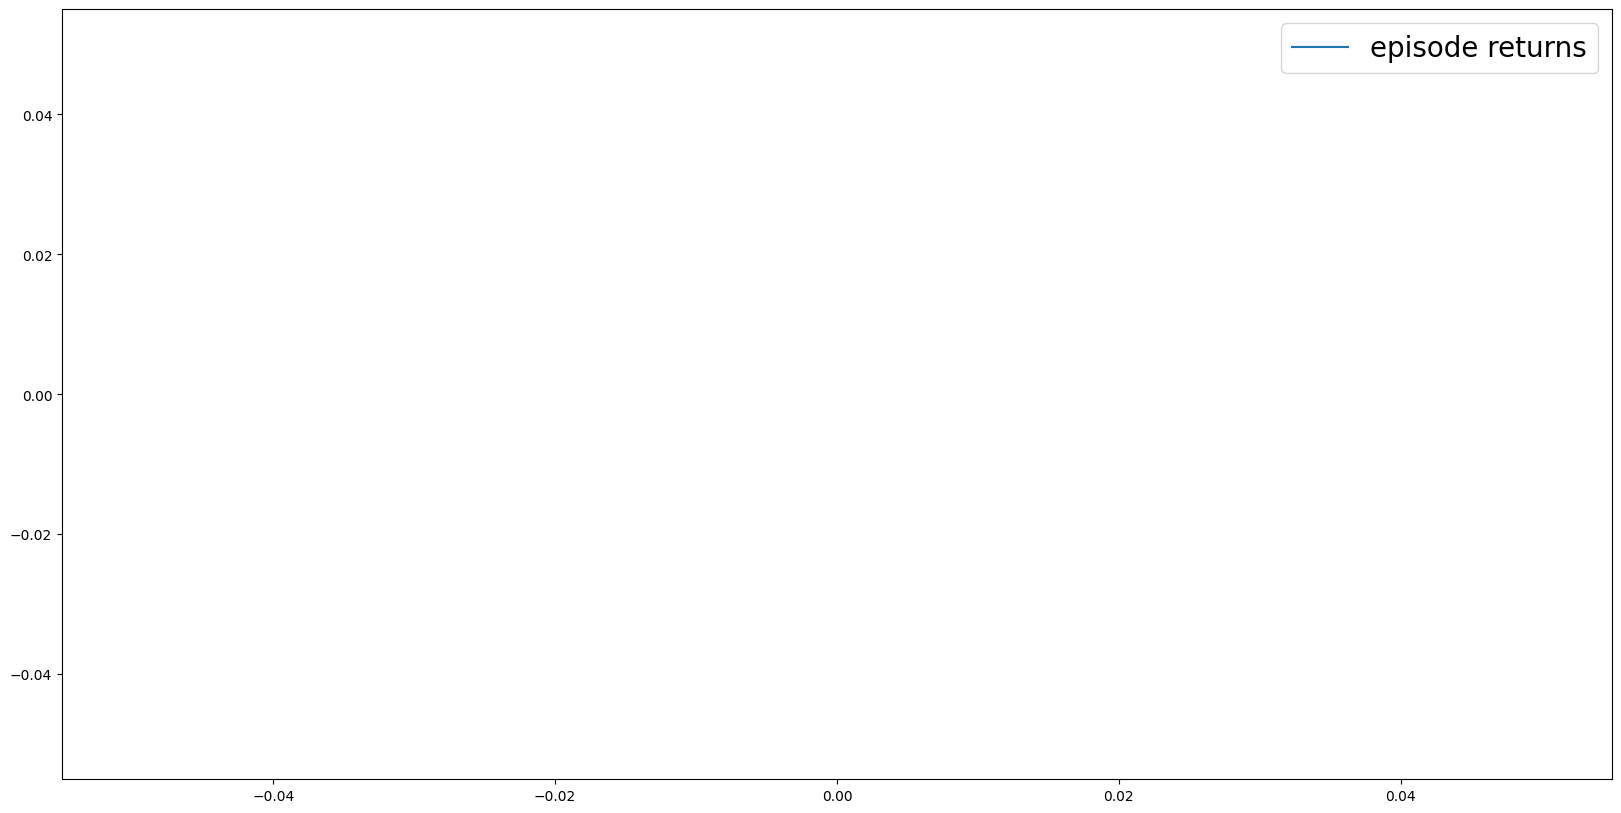

  0%|          | 10/15000 [08:29<315:50:44, 75.85s/it]

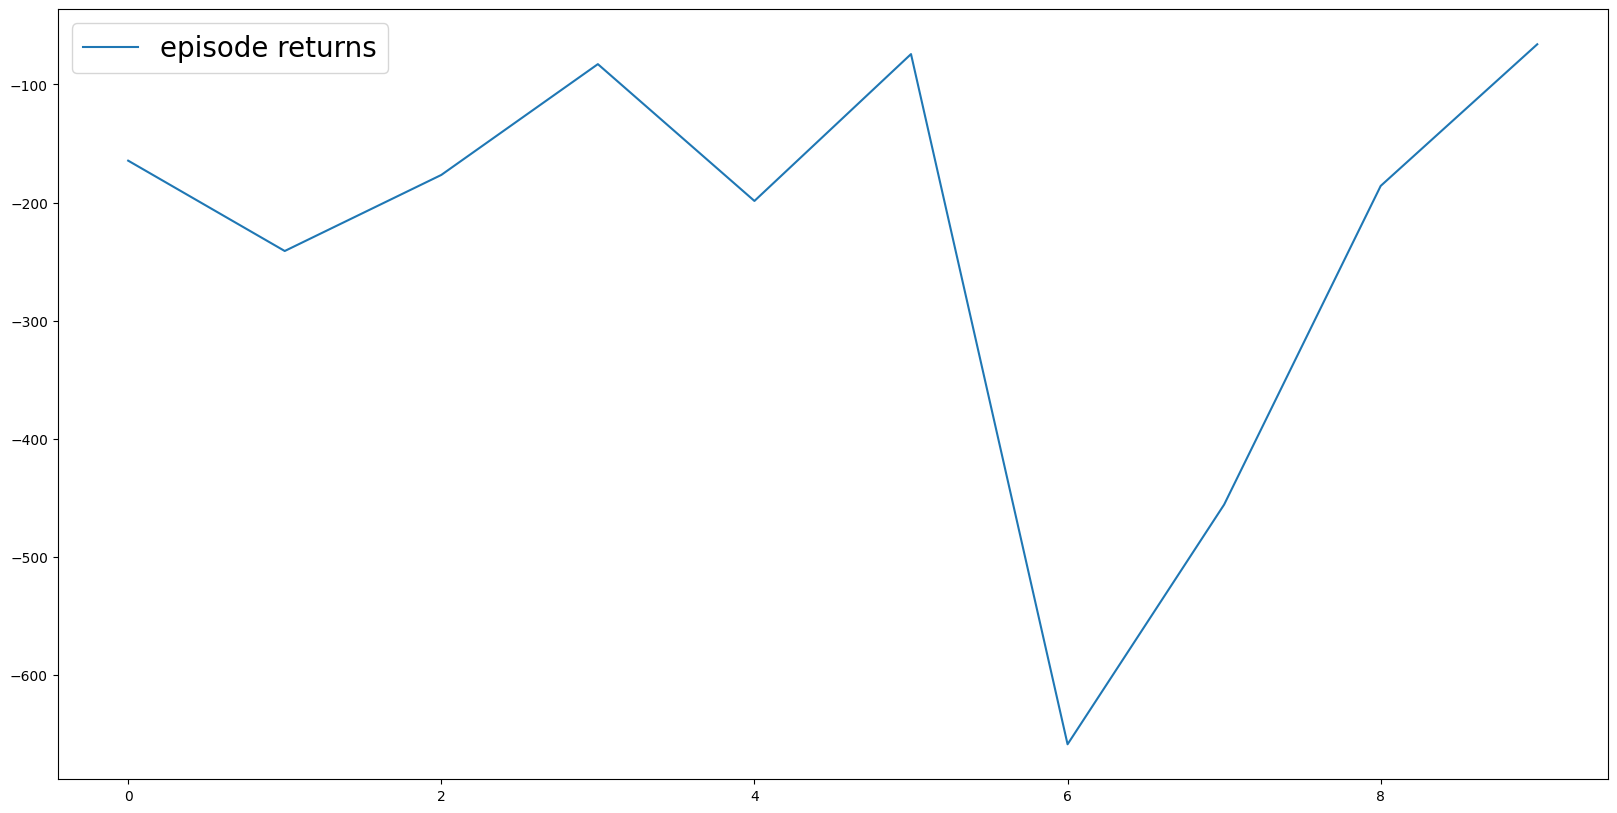

  0%|          | 20/15000 [22:20<348:01:32, 83.64s/it]

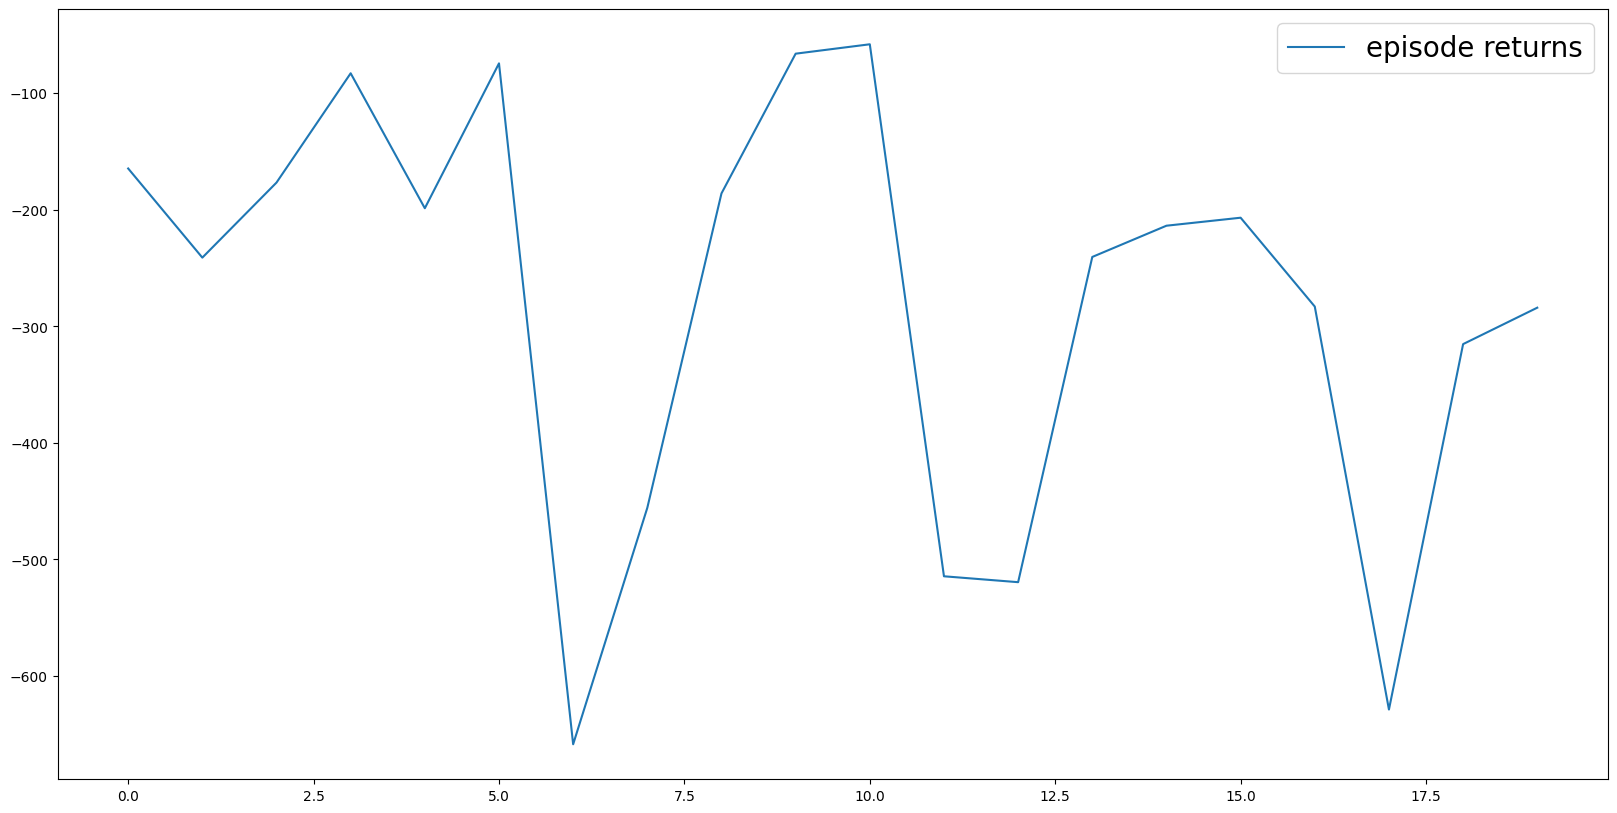

  0%|          | 21/15000 [24:04<286:13:39, 68.79s/it]


KeyboardInterrupt: 

In [ ]:
num_epis, epi_rews = 15000, []
memory = ReplayBuffer(AC_config)

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    cnt = 0
    while not (terminated or truncated):
        cnt += 1
        state = torch.Tensor(state)

        if n_epi == 0 and cnt == 1:
          target_critic = critic1

        action , policy = actor(1 , state)
        action = action.squeeze(0)

        if np.random.rand(1) < 0.001:
          action = env.action_space.sample()
        else:
          action = action.detach().numpy()

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.Tensor(next_state)

        next_action , next_policy = actor(1 , next_state)
        next_action = next_action.squeeze(0)

        memory.put([state, action, next_action , reward , next_state, terminated or truncated , cnt])

        if memory.size() > 4000 and cnt % 2 == 0:
          for i in range(5):

            states , actions, next_actions, rewards , next_states, dones, times = memory.sample(AC_config.batch_size)

            actor_optimizer.zero_grad()
            critic1_optimizer.zero_grad()
            critic2_optimizer.zero_grad()

            action , policy = actor(states.shape[0] , states)
            q1 = critic1(states, actions)
            q2 = critic2(states, actions)

            next_action, next_policy = actor(next_states.shape[0], next_states)

            if sum(critic1(next_states,next_actions)) > sum(critic2(next_states, next_actions)):
              least_q = critic2
            else:
              least_q = critic1

            a = alpha(states)

            soft_update(target_critic , least_q , 0.005)

            actor_loss = -least_q(states,actions) - a * policy
            critic_loss1 = (q1 - (rewards + AC_config.gamma * target_critic(next_states,next_actions)))**2
            critic_loss2 = (q2 - (rewards + AC_config.gamma * target_critic(next_states,next_actions)))**2
            alpha_loss = -least_q(states,actions) + torch.relu(-(0.005/AC_config.action_dim) + a * policy)

            actor_loss = actor_loss.mean()
            critic1_loss = critic_loss1.mean()
            critic2_loss = critic_loss2.mean()
            alpha_loss = alpha_loss.mean()

            actor_loss.backward(retain_graph=True)
            critic1_loss.backward(retain_graph=True)
            critic2_loss.backward(retain_graph=True)
            alpha_loss.backward(retain_graph=True)

            actor_optimizer.step()
            critic1_optimizer.step()
            critic2_optimizer.step()
            alpha_optimizer.step()

        ## reward formulation
        next_state = torch.Tensor(next_state)

        # state transition
        state = next_state

        # record reward
        epi_rew += reward

    if n_epi % 10 == 0:
      plt.figure(figsize=(20, 10))
      plt.plot(epi_rews, label='episode returns')
      plt.legend(fontsize=20)
      plt.show()
      plt.close()

    epi_rews += [epi_rew]

In [ ]:
import os
os.environ['MUJOCO_GL']='egl'
env = gym.wrappers.RecordVideo(env, video_folder='./videos')

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
state,_ = env.reset()
terminated, truncated = False, False
for i in range(1):
    while not (terminated or truncated):
      state = torch.Tensor(state)
      action , policy = actor(state.shape[0] , state)
      action = action.detach().numpy()
      next_state, reward, terminated, truncated, _ = env.step(action)

      state = next_state

env.close()

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


In [ ]:
from IPython.display import Video
Video("./videos/rl-video-episode-0.mp4", embed=True)